In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
base_path = os.getcwd()
players_file = os.path.join(base_path, "Datos", "players_22.csv")

players = pd.read_csv(players_file, encoding="utf-8", low_memory=False)


features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)

data = players[features].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

mean_values = data.mean()
min_values = data.min()
max_values = data.max()

print("Medias de los parametros:\n")
print(f"Overall promedio: {mean_values['overall']:.2f}")
print(f"Overall min: {min_values['overall']:.2f}")
print(f"Overall max: {max_values['overall']:.2f}")
print(f"Potential promedio: {mean_values['potential']:.2f}")
print(f"Potential min: {min_values['potential']:.2f}")
print(f"Sueldo promedio (EUR): {mean_values['wage_eur']:.2f}")
print(f"Valor promedio (EUR): {mean_values['value_eur']:.2f}")
print(f"Edad promedio: {mean_values['age']:.2f}")

Medias de los parametros:

Overall promedio: 65.76
Overall min: 47.00
Overall max: 93.00
Potential promedio: 71.08
Potential min: 49.00
Sueldo promedio (EUR): 9021.72
Valor promedio (EUR): 2850451.81
Edad promedio: 25.19


In [3]:
# === K-MEANS CON 5 CLUSTERS ===
n_clusters = 7
model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
players["cluster"] = model.fit_predict(scaled_data)

In [4]:
cluster_summary = (
    players.groupby("cluster")[features]
    .mean()
    .round(2)
    .assign(num_players=players["cluster"].value_counts().sort_index())
)

print("\n=== Resumen por clúster ===")
print(cluster_summary)


=== Resumen por clúster ===
         overall  potential   wage_eur    value_eur    age  num_players
cluster                                                                
0          65.52      75.03    4356.48   1696435.59  21.59         5092
1          75.78      79.19   30041.57   9719751.63  25.94         1691
2          63.70      64.57    2363.20    555538.96  28.90         4312
3          81.23      83.74   79904.76  30538847.12  26.68          399
4          56.80      67.48    1279.88    383887.00  20.76         3814
5          86.78      88.75  187797.47  82075949.37  26.95           79
6          70.93      71.48   10092.18   1859695.61  29.76         3778


In [5]:
scaler_minmax = MinMaxScaler()
cluster_features = cluster_summary[["potential", "overall", "value_eur", "wage_eur"]].copy()
cluster_scaled = pd.DataFrame(
    scaler_minmax.fit_transform(cluster_features),
    columns=cluster_features.columns
)

cluster_scaled["score"] = (
    cluster_scaled["potential"] * 0.4 + cluster_scaled["overall"] * 0.1 - cluster_scaled["value_eur"] * 1 - cluster_scaled["wage_eur"] * 0.35
)

# === SELECCIONAR MEJOR CLÚSTER ===
# En lugar de solo mirar potencial alto, miramos el mejor equilibrio
best_cluster = cluster_scaled["score"].idxmax()

print(f"\nClúster con mejor equilibrio potencial/costo: {best_cluster}")
print("\n=== Tabla de puntuación de clústeres ===")
print(cluster_scaled.round(3))


Clúster con mejor equilibrio potencial/costo: 0

=== Tabla de puntuación de clústeres ===
   potential  overall  value_eur  wage_eur  score
0      0.433    0.291      0.016     0.016  0.180
1      0.605    0.633      0.114     0.154  0.137
2      0.000    0.230      0.002     0.006  0.019
3      0.793    0.815      0.369     0.422 -0.118
4      0.120    0.000      0.000     0.000  0.048
5      1.000    1.000      1.000     1.000 -0.850
6      0.286    0.471      0.018     0.047  0.127


In [6]:
# === MOSTRAR JUGADORES DESTACADOS DEL CLÚSTER OBJETIVO ===
jugadores_objetivo = players.loc[players["cluster"] == best_cluster]

top_jugadores = jugadores_objetivo[
    ["short_name", "overall", "potential", "value_eur", "wage_eur", "age"]
].sort_values(by=["potential", "value_eur"], ascending=[False, True]).head(50)

print("\n=== Jugadores del clúster objetivo ===")
print(top_jugadores)


=== Jugadores del clúster objetivo ===
                short_name  overall  potential  value_eur  wage_eur  age
9771                 Kayky       66         87  2700000.0   12000.0   18
5421            N. Rovella       70         87  4100000.0   19000.0   19
4479        M. Vandevoordt       71         87  4300000.0    3000.0   19
13245          D. Scarlett       63         86  1500000.0    3000.0   17
9726              C. Clark       66         86  2400000.0    6000.0   18
8414           L. Stergiou       67         86  2500000.0    2000.0   19
8564           F. Carvalho       67         86  2600000.0    6000.0   18
7441              B. Šeško       68         86  3100000.0    5000.0   18
5457   Francisco Conceição       70         86  4000000.0    3000.0   18
3808         Gonçalo Ramos       72         86  5500000.0    8000.0   20
14349             R. Lavia       62         85  1200000.0     700.0   17
12095             L. Delap       64         85  1900000.0    9000.0   18
9800       

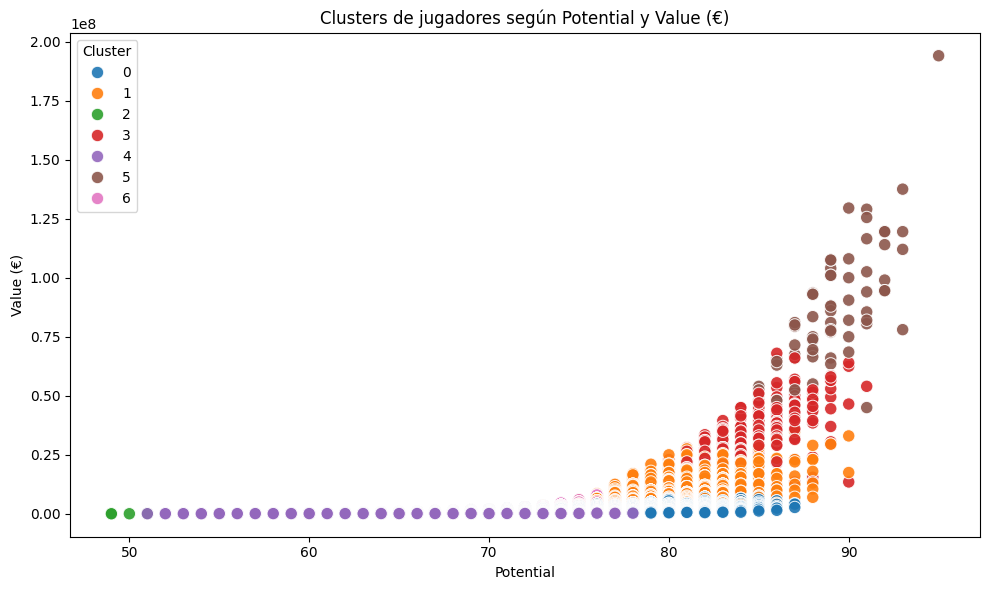

In [7]:
# Mapa de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=0.9, s=80
)
plt.title("Clusters de jugadores según Potential y Value (€)")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

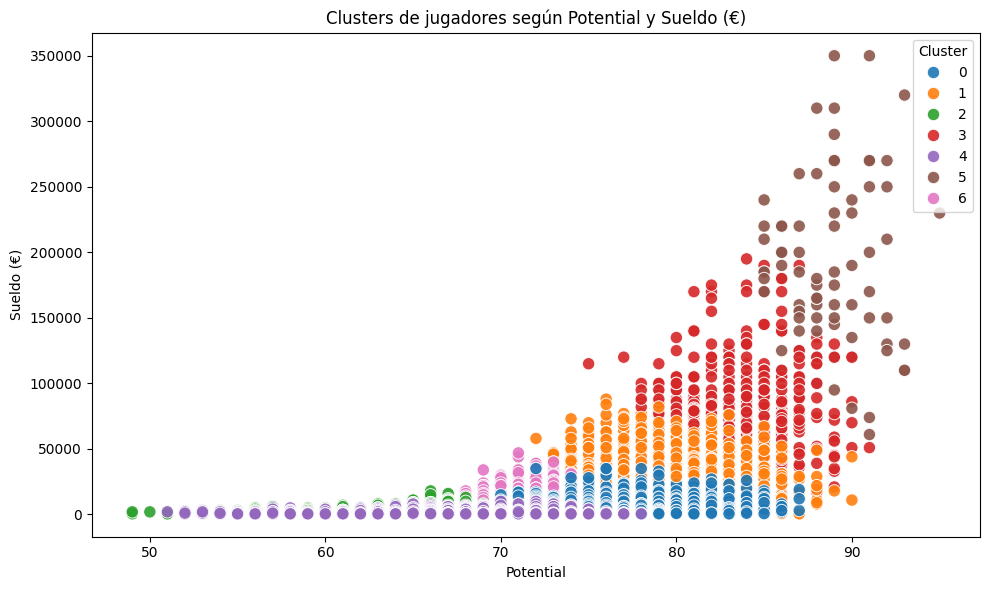

In [8]:
# Mapa de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="wage_eur",
    hue="cluster", palette="tab10", alpha=0.9, s=80
)
plt.title("Clusters de jugadores según Potential y Sueldo (€)")
plt.xlabel("Potential")
plt.ylabel("Sueldo (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

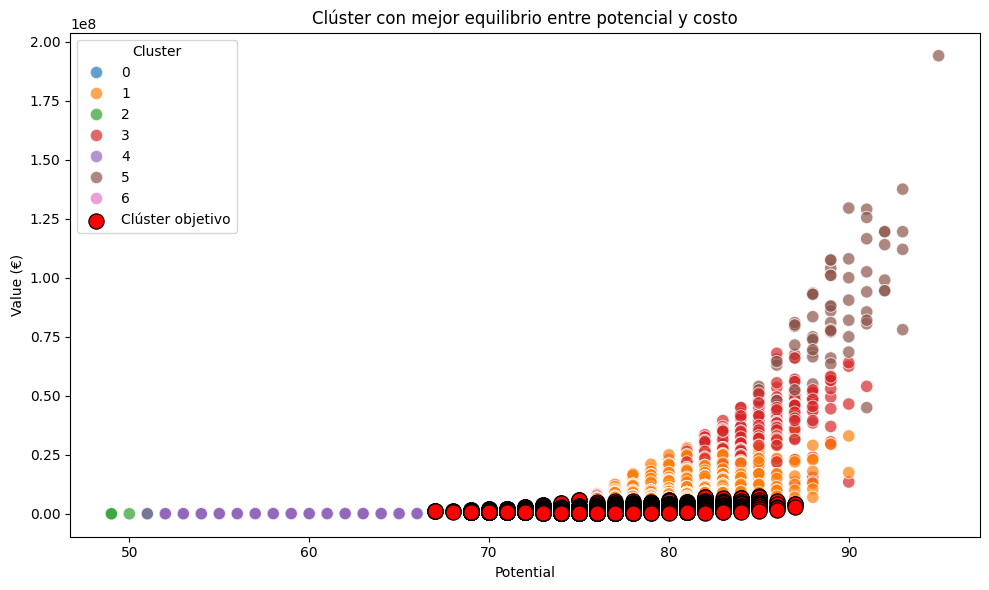

In [9]:
# Resaltar clúster objetivo
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=0.7, s=80
)
sns.scatterplot(
    data=jugadores_objetivo, x="potential", y="value_eur",
    color="red", s=120, label="Clúster objetivo", edgecolor="k"
)
plt.title("Clúster con mejor equilibrio entre potencial y costo")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

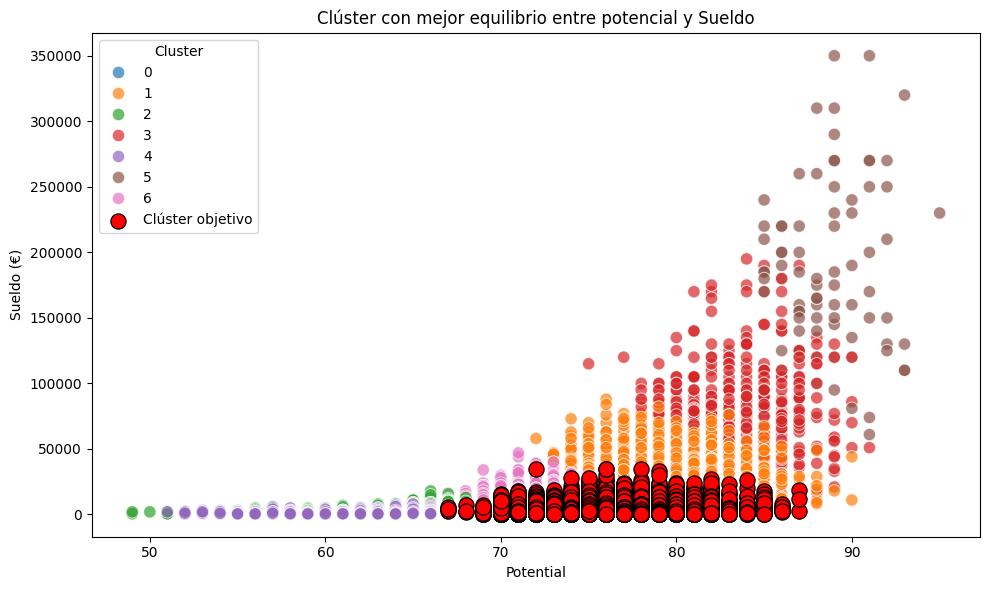

In [10]:
# Resaltar clúster objetivo
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="wage_eur",
    hue="cluster", palette="tab10", alpha=0.7, s=80
)
sns.scatterplot(
    data=jugadores_objetivo, x="potential", y="wage_eur",
    color="red", s=120, label="Clúster objetivo", edgecolor="k"
)
plt.title("Clúster con mejor equilibrio entre potencial y Sueldo")
plt.xlabel("Potential")
plt.ylabel("Sueldo (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()